<a href="https://colab.research.google.com/github/spregler/Plant-Pathology-Capstone/blob/master/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
!pip install --upgrade --force-reinstall --no-deps kaggle

# set kaggle json dir
import os
#Personal example
os.environ['KAGGLE_CONFIG_DIR'] = "/project/.kaggle"
os.environ['KAGGLE_USERNAME'] = "spregler"
os.environ['KAGGLE_KEY'] = "e910c1636cfb935a5f3f382a1aefa24c"

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=509ce4321bce0f8eb8772707dbae90999de0d7b6f81fcc985d85bdbcbceef71e
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [0]:
%cd /project/

/project


In [0]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

 98% 763M/779M [00:04<00:00, 228MB/s]
100% 779M/779M [00:04<00:00, 189MB/s]


In [0]:
!unzip plant-pathology-2020-fgvc7

In [0]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 49.0MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
!pip install neptune-client
!pip install neptune-contrib
!pip install neptune-contrib[monitoring]

# Import Dependencies & Extract Data

In [0]:
import neptune

neptune.init(
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMTA3NjRiMTQtMWM0MS00YmVjLTliYzAtMzYwYWJkNmNlY2IyIn0=',
    project_qualified_name='spregler/fastai'
)

Project(spregler/fastai)

In [0]:
import os 
from pathlib import Path

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import fastai
import fastai.vision
from fastai import *
from fastai.vision import *
from fastai.vision import learner
from sklearn.metrics import *

import pandas as pd
import numpy as np

root_dir = Path("/project/") # Local path object in colab
train_df = pd.read_csv('/project/train.csv')
test_df = pd.read_csv("/project/test.csv")
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


# Transform Data w/ Helper Function

In [0]:
def transformPipeline(df):
  # Creates a class column and assign it to the index which produces the max value for each row
  df['class'] = np.argmax(train_df.loc[:, ['healthy','multiple_diseases','rust','scab']].values, axis=1)
  # Drops columnns that are no longer of use
  df.drop(columns=['healthy','multiple_diseases','rust','scab'], inplace=True)
  print("Transformed df: ")
  print(train_df.head())


In [0]:
transformPipeline(train_df)

Transformed df: 
  image_id  class
0  Train_0      3
1  Train_1      1
2  Train_2      0
3  Train_3      2
4  Train_4      0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faac97d2588>]], dtype=object)

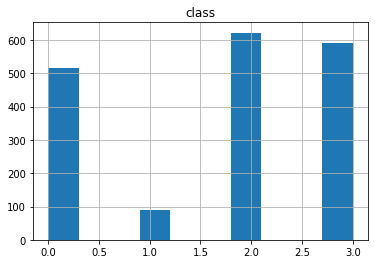

In [0]:
train_df.hist() # we have imbalanced data!

In [0]:
train_df['class'].value_counts(sort=False)

0    516
1     91
2    622
3    592
Name: class, dtype: int64

# Create ImageList Object Using DataBlocks API

In [0]:
np.random.seed(42)
src = (ImageList.from_df(train_df, root_dir, folder='images', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df())

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.5, max_rotate=90.0)

data = (src.transform(tfms, size=224)
      .databunch(bs=64)
      .normalize(imagenet_stats))

In [0]:
data.show_batch(rows=4)

# Training

The following cell integrates the Neptune API with the Fastai framework. Neptune is an experiment management tool that is helpful for keeping track of experiments and logging metrics.

In [0]:
from fastai.callbacks import *
from neptunecontrib.monitoring.fastai import NeptuneMonitor

arch = models.resnet50 # define model

with neptune.create_experiment(params={'lr':1e-3}):
  learner = cnn_learner(data, arch, metrics=[accuracy , error_rate],
                        callback_fns=[NeptuneMonitor], wd=1e-3).to_fp32()
  learner.fit_one_cycle(5, 1e-3) # fit to our data

https://ui.neptune.ai/spregler/fastai/e/FAS-19


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.967101,0.723352,0.793956,0.206044,02:13
1,0.727346,0.376899,0.879121,0.120879,02:11
2,0.556619,0.309270,0.903846,0.096154,02:10
3,0.442780,0.286657,0.909341,0.090659,02:09
4,0.364213,0.254941,0.917582,0.082418,02:09


https://ui.neptune.ai/spregler/fastai/e/FAS-20


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 6.31E-08


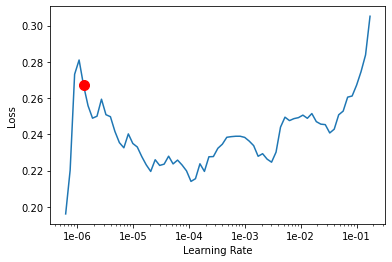

In [0]:
with neptune.create_experiment():
  learner.lr_find() # find optimal lr
  learner.recorder.plot(suggestion=True)

In [0]:
learner.save('resnet50-stage0')
learner.load('resnet50-stage0')
learner.unfreeze()

In [0]:
with neptune.create_experiment():
  learner.fit_one_cycle(11, slice(1.5e-05,1e-04))

https://ui.neptune.ai/spregler/fastai/e/FAS-23


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.221175,0.216680,0.928571,0.071429,02:09
1,0.221483,0.196176,0.939560,0.060440,02:09
2,0.205669,0.216524,0.942308,0.057692,02:08
3,0.177416,0.309395,0.936813,0.063187,02:07
4,0.164009,0.183610,0.953297,0.046703,02:09
5,0.134531,0.276811,0.947802,0.052198,02:09
6,0.119500,0.149928,0.967033,0.032967,02:10
7,0.112415,0.155664,0.961538,0.038462,02:10
8,0.105971,0.147462,0.967033,0.032967,02:09
9,0.097280,0.153888,0.969780,0.030220,02:09


In [0]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

359 misclassified samples over 364 samples in the validation set.


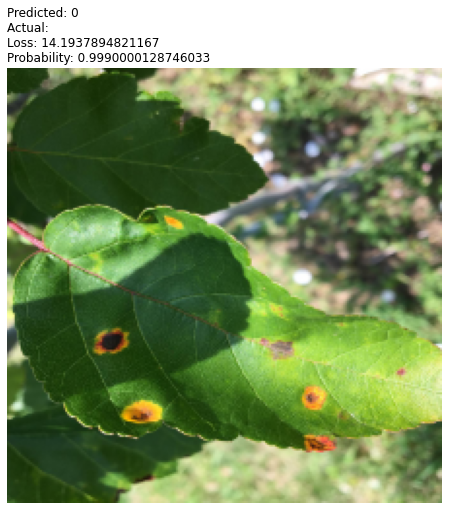

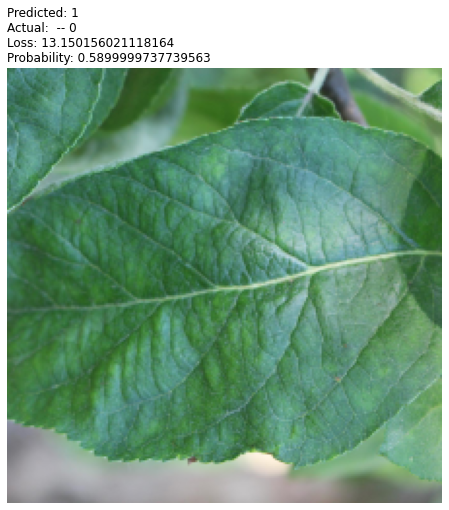

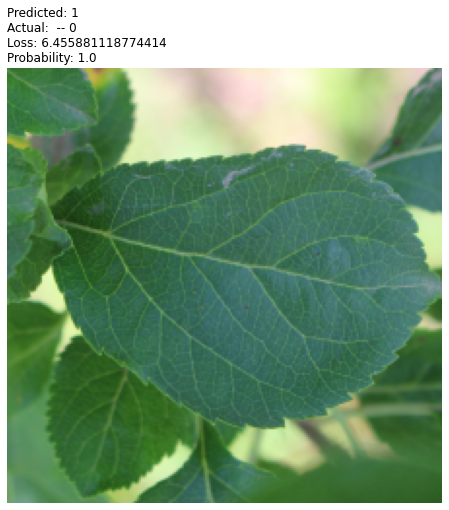

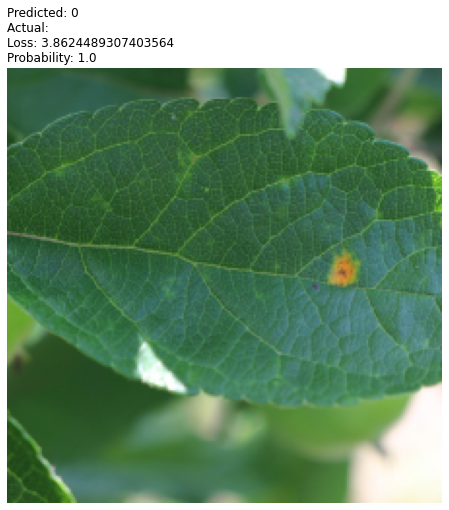

In [0]:
interp.plot_multi_top_losses(samples=4)

In [0]:
learner.save('resnet50-stage1')

In [0]:
learner.export()

In [0]:
test_data = ImageList.from_df(test_df, root_dir, folder='images', suffix='.jpg')
data.add_test(test_data)

In [0]:
learn = load_learner('/project/')

In [0]:
preds, y = learn.get_preds() 

# Kaggle Competition Stuff




In [0]:
sample_df = pd.read_csv(root_dir/'sample_submission.csv')
sample_df.iloc[:,1:] = preds.numpy()
sample_df.to_csv('submission.csv', index=False)

In [0]:
import pickle 
learner.export() # Save model for inference to export.pkl

# Conclusion:
The end model was able to acheive a score of .922 on the kaggle challenge learderboard: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/leaderboard

Just by tuning a ResNet50, we were able to acheive an accuracy of 0.975.

The origninal paper outlining this challenge can be found: https://arxiv.org/abs/2004.11958